              Open         High          Low        Close    Adj Close  \
count  2014.000000  2014.000000  2014.000000  2014.000000  2014.000000   
mean     72.995713    73.831312    72.182233    73.038039    70.810326   
std      48.953033    49.604854    48.304993    48.976245    49.100044   
min      22.500000    22.917500    22.367500    22.584999    20.744019   
25%      32.328125    32.642502    32.080626    32.348750    29.166351   
50%      48.039999    48.582500    47.775000    48.165001    45.990999   
75%     123.727501   125.130001   122.192499   123.697500   121.418709   
max     182.630005   182.940002   179.119995   182.009995   179.481125   

             Volume  
count  2.014000e+03  
mean   1.317725e+08  
std    6.786645e+07  
min    3.519590e+07  
25%    8.628720e+07  
50%    1.121376e+08  
75%    1.565594e+08  
max    6.488252e+08  


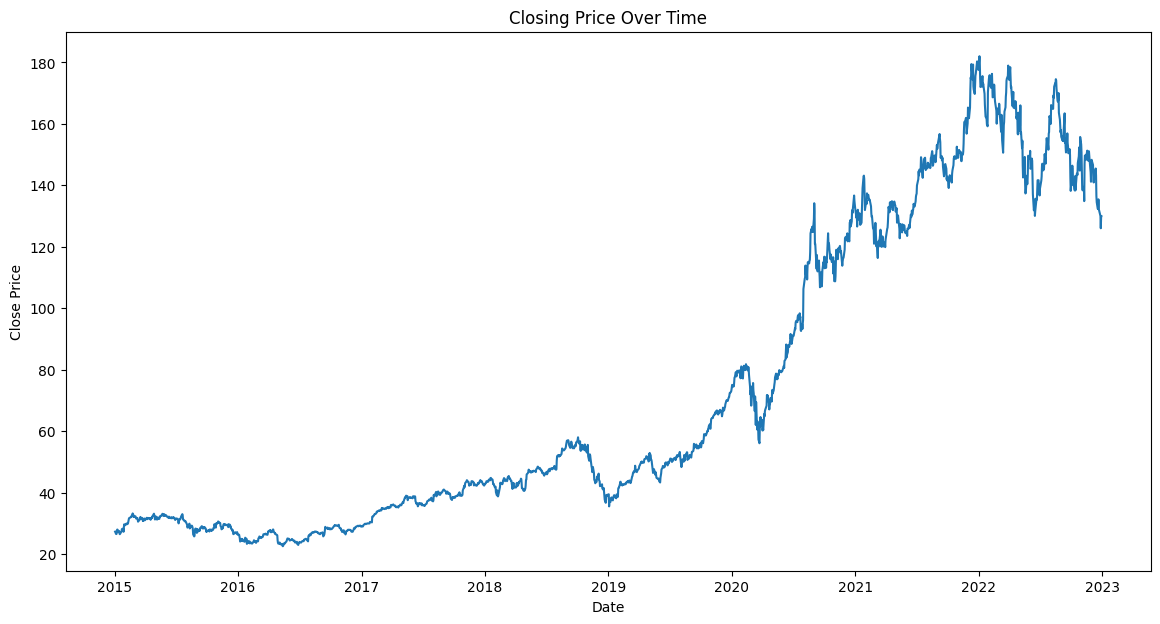

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("historical_stock_data.csv", index_col='Date', parse_dates=True)

# Basic summary statistics
print(data.describe())

# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()



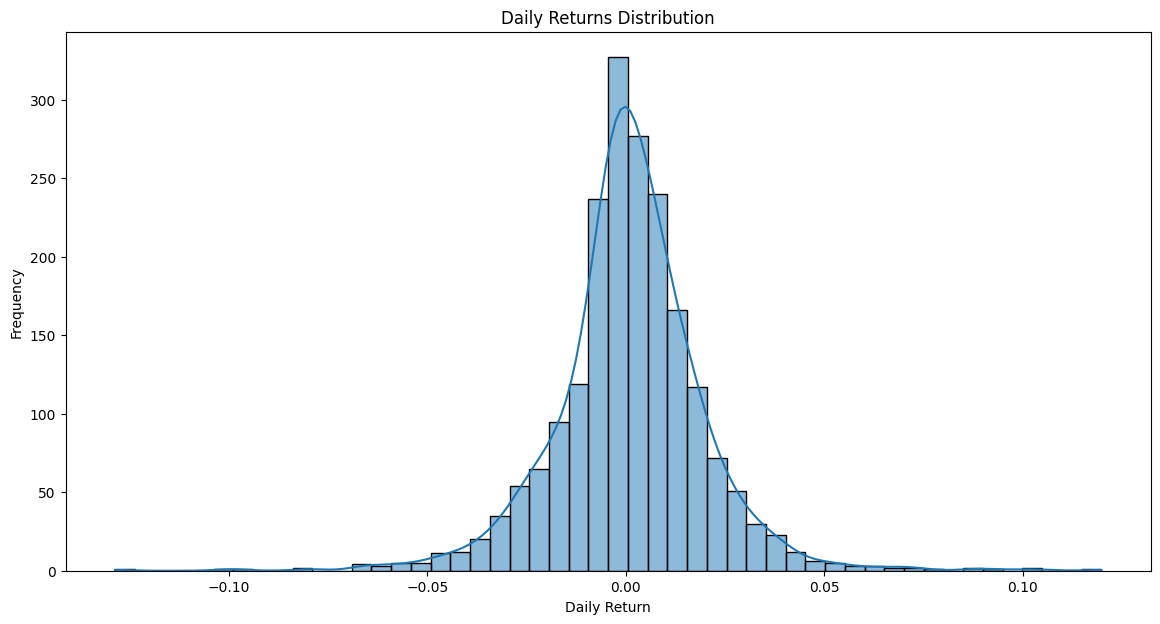

In [3]:
# Plot daily returns
data['Daily Return'] = data['Close'].pct_change()
plt.figure(figsize=(14, 7))
sns.histplot(data['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


In [5]:
def fitness_func(solution):
    stop_loss_percentage, take_profit_percentage = solution
    capital = 10000  # Starting capital
    position = 0  # Current position (0 = no position, 1 = holding the stock)
    buy_price = 0

    for index, row in data.iterrows():
        if position == 0:
            # Buy condition: Buy at the close price
            buy_price = row['Close']
            position = 1

        elif position == 1:
            # Sell condition: Implement stop-loss and take-profit
            if row['Close'] <= buy_price * (1 - stop_loss_percentage) or row['Close'] >= buy_price * (1 + take_profit_percentage):
                capital += (row['Close'] - buy_price) * (capital / buy_price)
                position = 0

    return capital


In [6]:
import numpy as np

def initialize_population(pop_size, num_genes, gene_space):
    population = []
    for _ in range(pop_size):
        individual = [np.random.uniform(gene_space[0][0], gene_space[0][1]),
                      np.random.uniform(gene_space[1][0], gene_space[1][1])]
        population.append(individual)
    return np.array(population)

pop_size = 10
num_genes = 2
gene_space = [(0.01, 0.1), (0.01, 0.2)]
population = initialize_population(pop_size, num_genes, gene_space)


In [7]:
def select_parents(population, fitness, num_parents):
    parents = np.empty((num_parents, population.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999  # This value is chosen to exclude the selected parent
    return parents


In [8]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k+1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


In [9]:
def mutation(offspring, gene_space, mutation_rate=0.1):
    for idx in range(offspring.shape[0]):
        if np.random.rand() < mutation_rate:
            gene_idx = np.random.randint(0, offspring.shape[1])
            random_value = np.random.uniform(gene_space[gene_idx][0], gene_space[gene_idx][1])
            offspring[idx, gene_idx] = random_value
    return offspring


In [11]:
import pandas as pd

# Load the dataset
data = pd.read_csv("historical_stock_data.csv", index_col='Date', parse_dates=True)

# Parameters
num_generations = 50
num_parents_mating = 5
mutation_rate = 0.1

for generation in range(num_generations):
    # Calculate fitness
    fitness = np.array([fitness_func(individual) for individual in population])

    # Select parents
    parents = select_parents(population, fitness, num_parents_mating)

    # Generate next generation
    offspring_size = (pop_size - parents.shape[0], num_genes)
    offspring_crossover = crossover(parents, offspring_size)
    offspring_mutation = mutation(offspring_crossover, gene_space, mutation_rate)

    # Create the new population
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation

    # Best solution in the current generation
    best_fitness_idx = np.where(fitness == np.max(fitness))[0][0]
    best_solution = population[best_fitness_idx, :]
    print(f"Generation {generation}: Best solution: Stop-Loss Percentage = {best_solution[0]}, Take-Profit Percentage = {best_solution[1]}, Fitness (Ending Capital): {fitness[best_fitness_idx]}")

# Final best solution
fitness = np.array([fitness_func(individual) for individual in population])
best_fitness_idx = np.where(fitness == np.max(fitness))[0][0]
best_solution = population[best_fitness_idx, :]
print(f"Final best solution: Stop-Loss Percentage = {best_solution[0]}, Take-Profit Percentage = {best_solution[1]}")
print(f"Fitness (Ending Capital): {fitness[best_fitness_idx]}")


Generation 0: Best solution: Stop-Loss Percentage = 0.05242495418944316, Take-Profit Percentage = 0.03205094948953558, Fitness (Ending Capital): 43426.690035581734
Generation 1: Best solution: Stop-Loss Percentage = 0.055373771112154274, Take-Profit Percentage = 0.03205094948953558, Fitness (Ending Capital): 46016.737332096236
Generation 2: Best solution: Stop-Loss Percentage = 0.01143465702841011, Take-Profit Percentage = 0.10540085623026392, Fitness (Ending Capital): 50287.75768521743
Generation 3: Best solution: Stop-Loss Percentage = 0.01143465702841011, Take-Profit Percentage = 0.10540085623026392, Fitness (Ending Capital): 65942.26298824727
Generation 4: Best solution: Stop-Loss Percentage = 0.01143465702841011, Take-Profit Percentage = 0.10540085623026392, Fitness (Ending Capital): 65942.26298824727
Generation 5: Best solution: Stop-Loss Percentage = 0.01143465702841011, Take-Profit Percentage = 0.10540085623026392, Fitness (Ending Capital): 65942.26298824727
Generation 6: Best 